<a href="https://colab.research.google.com/github/arminarj/convex-optimization-boyd/blob/master/Standard_form_LP_barrier_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [0]:
## Generating A, b, c, x_init:
np.random.seed(0)
m, n = 100, 500
while(True):
    A = np.random.rand(m, n)
    A += np.ones((m, n)) * 0.01 # more numerical stability
    if np.linalg.matrix_rank(A) == A.shape[0]:
        break

x_init = np.absolute(np.random.rand(n))

b = A @ x_init
c = np.random.rand(n)

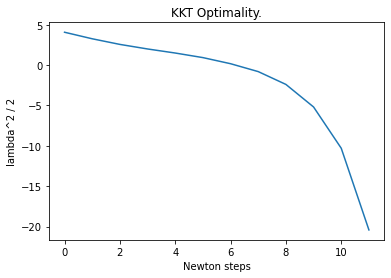

In [0]:
def LP(A, b, c, x_init, MAX_ITER=100, alfa=1e-2, beta=0.5, verbos=True):
    '''
    output : X_star, Nu_star, Lambda_log
    '''
    def plot_lambda(iteration, lambda_log):
        plt.figure()
        plt.title('KKT Optimality.')
        plt.xlabel('Newton steps')
        plt.ylabel('lambda^2 / 2')
        plt.plot(np.log(lambda_log))
        plt.show()

    alpa = 0
    eps = 1e-6
    num_estb = 1e-10

    m, n  = b.shape, x_init.shape 
    if (np.min(x_init) <= 0):
        print('Failed, x0 not positive')
        return None, None , None
    if np.linalg.norm((A@x_init - b), 2) >= eps:
        print('Failed, Ax - b not close to 0')
        return None, None , None
    
    lambda_log = []
    x = x_init
    for iteration in range(MAX_ITER):

        ## KKT Systems:

        g = c - (1 / (x + num_estb)) # gradient
        H = np.diag(np.square(1 / (x + num_estb))) # Hessian

        x2_diag = np.diag(np.square(x))
        w  = np.linalg.lstsq( A @ x2_diag @ A.T, (-A @ x2_diag @ g), rcond=None)[0]
        delta_x  = - x2_diag @ (A.T @ w + g)

        lambda_2 = - delta_x.T @ g
        lambda_log.append(lambda_2/2)

        # Stopping criterion
        if lambda_2/2 <= eps :
            if verbos:
                plot_lambda(iteration, lambda_log)
            return x, w, lambda_log

        # Backtracking Line Search :
        t = 1

        while(np.min(x + t * delta_x) <= 0):
            t = beta * t

        while(True):
            if not ( c.T @ (t * delta_x) - np.sum( np.log(x + delta_x * t) ) + np.sum(np.log(x)) - alfa * t * g.T @ delta_x) > 0:                
                break
            else: t = t * beta 

        x = x + t * delta_x

    print('Maximum iteration reached')
    return None, None, lambda_log


X_star, Nu_star, Lambda_log = LP(A, b, c, x_init)

 Part B:

In [0]:
## Generating A, b, c, x_init:
np.random.seed(1234)
m, n = 100, 500
while(True):
    A = np.random.rand(m, n)
    A += np.ones((m, n)) * 0.01 # more numerical stability
    if np.linalg.matrix_rank(A) == A.shape[0]:
        break

x_init = np.absolute(np.random.rand(n))

b = A @ x_init
c = np.random.rand(n)

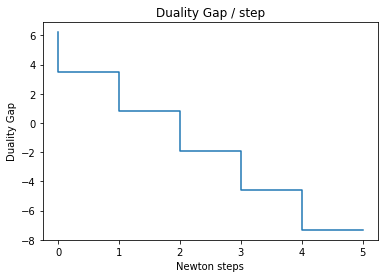

In [0]:
def barrier_method(A, b, c, x_init, MAX_ITER=100, alfa=1e-2,
                        beta=0.5, verbos=True, slv_verbos=False):

    def plot_gap(logs):
        plt.figure()
        plt.title('Duality Gap / step')
        plt.xlabel('Newton steps')
        plt.ylabel('Duality Gap')
        plt.step(range(len(logs[1])),np.log(logs[1]))
        plt.show()  
    # Barrier:
    eps = 1e-3
    stb_param = 1e-10
    T_init = 1
    mu = 15 # usually between [10, 20] 
    n = len(x_init)
    logs = ([], [])
    t = T_init
    while(True):
        X_star, Nu_star, Lambda_log = LP(A, b, c, x_init, alfa=alfa, beta=beta, verbos=slv_verbos)
        x = X_star
        dual_gap = n / (t+stb_param)
        logs[0].append(len(Lambda_log))
        logs[1].append(dual_gap)
        if dual_gap <= eps:
            if verbos:
                plot_gap(logs)
            return x, logs, dual_gap
        t = t * mu

x_star, logs, gap = barrier_method(A, b, c, x_init, verbos=True)

### comparing with CVXPY

In [0]:
TEST_LIMIT = 100
np.random.seed(111)

for t in range(TEST_LIMIT):
    ## out Solution:
    m, n = 100, 500
    while(True):
        A = np.random.rand(m, n)
        A += np.ones((m, n)) * 0.01 # more numerical stability
        if np.linalg.matrix_rank(A) == A.shape[0]:
            break
    x_init = np.absolute(np.random.rand(n))
    b = A @ x_init
    c = np.random.rand(n)

    x_star, logs, gap = barrier_method(A, b, c, x_init, verbos=False)

    ## CVX solution:
    x = cp.Variable(n)
    obj_function =  c.T @ x - cp.sum(cp.log(x))
    obj = cp.Minimize(obj_function)
    constraints  = [
                    A @ x == b,
                    x >= 0,
        ]
    prob = cp.Problem(obj, constraints)
    try:
        prob.solve()
        X_CVX_star  = prob.value
    except Exception as e:
        print(e)
        break
    assert( np.allclose(X_CVX_star, x_star, 1e-6) )


AssertionError: ignored

# Part C : LP solver


In [0]:
class LPSolver():
    def __init__(self):
        super(LPSolver).__init__()
        self.INF = np.float('inf')
        self.status = None

    def solve(self, A, b, c):
        nstep = (0, 0)

        # Phase I

        m, n = A.shape
        x0 = np.linalg.lstsq( A, b, rcond=None)[0]
        if np.min(x0) > 0 :
            ## Stricly feasible point
            pass
        t0 = 2 - np.maximum(0, np.min(x0))
        A1 = np.concatenate([A, (-A @ np.ones((n, 1)))], axis=1)
        b1 = b - A @ np.ones((n,1))
        z0 = x0 + t0 * np.ones(n) - np.ones(n) # 𝑧 = 𝑥 + (𝑡 − 1)𝟏
        print(z0.shape)
        c1 = np.zeros((n+1, 1)); c1[-1, :] = 1;
        z_star, logs, gap = self.barrier_method(A1, b1, c1, np.hstack([z0, t0]), verbos=False)
        t = z_star[-1]
        nstep[0] = np.sum(logs[0])
        if t >= 1:
            print('The problom is infeasible.')
            self.status = 'Infeasible'; gap = None;
            return None, self.INF, gap, nstep
        print('A feasible point found.')
        x0 = z_star[:n] + (1 - z_star[-1])* np.ones((n, 1))

        # Phase II

        x_star, logs, gap = self.barrier_method(A, b, c, x_0, verbos=False)
        self.status = 'Solved'
        p_star = c.T @ x_star
        nstep[1] = np.sum(logs[0])
        return x_star, p_star, gap, nstep


    def barrier_method(self, A, b, c, x_init, MAX_ITER=100, alfa=1e-2,
                            beta=0.5, verbos=True, slv_verbos=False):

        def plot_gap(logs):
            plt.figure()
            plt.title('Duality Gap / step')
            plt.xlabel('Newton steps')
            plt.ylabel('Duality Gap')
            plt.step(range(len(logs[1])),np.log(logs[1]))
            plt.show()  
        # Barrier:
        eps = 1e-3
        stb_param = 1e-10
        T_init = 1
        mu = 15 # usually between [10, 20] 
        n = len(x_init)
        logs = ([], [])
        t = T_init
        while(True):
            X_star, Nu_star, Lambda_log = self.LP(A, b, c, x_init, alfa=alfa, beta=beta, verbos=slv_verbos)
            x = X_star
            dual_gap = n / (t+stb_param)
            logs[0].append(len(Lambda_log) if Lambda_log is not None else 0)
            logs[1].append(dual_gap)
            if dual_gap <= eps:
                if verbos:
                    plot_gap(logs)
                return x, logs, dual_gap
            t = t * mu

    def LP(self, A, b, c, x_init, MAX_ITER=100, alfa=1e-2, beta=0.5, verbos=True):
        '''
        output : X_star, Nu_star, Lambda_log
        '''
        def plot_lambda(iteration, lambda_log):
            plt.figure()
            plt.title('KKT Optimality.')
            plt.xlabel('Newton steps')
            plt.ylabel('lambda^2 / 2')
            plt.plot(np.log(lambda_log))
            plt.show()

        alpa = 0
        eps = 1e-6
        num_estb = 1e-10

        m, n  = A.shape
        if (np.min(x_init) <= 0):
            print('Failed, x0 not positive')
            return None, None , None
        if np.linalg.norm((A@x_init - b), 2) >= eps:
            print('Failed, Ax - b not close to 0')
            return None, None , None
        
        lambda_log = []
        x = x_init
        for iteration in range(MAX_ITER):

            ## KKT Systems:

            g = c - (1 / (x + num_estb)) # gradient
            H = np.diag(np.square(1 / (x + num_estb))) # Hessian

            x2_diag = np.diag(np.square(x))
            w  = np.linalg.lstsq( A @ x2_diag @ A.T, (-A @ x2_diag @ g), rcond=None)[0]
            delta_x  = - x2_diag @ (A.T @ w + g)

            lambda_2 = - delta_x.T @ g
            lambda_log.append(lambda_2/2)

            # Stopping criterion
            if lambda_2/2 <= eps :
                if verbos:
                    plot_lambda(iteration, lambda_log)
                return x, w, lambda_log

            # Backtracking Line Search :
            t = 1
            while(np.min(x + t * delta_x) <= 0):
                t = beta * t

            while(True):
                if not ( c.T @ (t * delta_x) - np.sum( np.log(x + delta_x * t) ) + np.sum(np.log(x)) - alfa * t * g.T @ delta_x) > 0:                
                    break
                else: t = t * beta 

            x = x + t * delta_x

        print('Maximum iteration reached')
        return None, None, lambda_log



In [0]:
my_solver = LPSolver()

## Generating A, b, c, x_init:
np.random.seed(1234321)
m, n = 100, 500
while(True):
    A = np.random.rand(m, n)
    A += np.ones((m, n)) * 0.01 # more numerical stability
    if np.linalg.matrix_rank(A) == A.shape[0]:
        break
b = np.random.rand(m)
c = np.random.rand(n)

my_solver.solve(A, b, c)

(500,)
Failed, Ax - b not close to 0
Failed, Ax - b not close to 0
Failed, Ax - b not close to 0
Failed, Ax - b not close to 0
Failed, Ax - b not close to 0
Failed, Ax - b not close to 0


TypeError: ignored